# Pendulum simulation

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

Before simulating we need to import the class from the build module:

In [3]:
from pydae import ssa
from pendulum import pendulum_class

Then you can create an instance of the class:

In [4]:
pend = pendulum_class()

## Initialization

The `initialize` method gives the steady state of the system by solving first the backward and then the forward problems.
In this case 

In [5]:
M = 30.0  # mass of the bob (kg)
L = 5.21  # length of the pendulum (m)
pend.initialize([{
                 'M':M,'L':L,           # parameters setting
                 'theta':np.deg2rad(0)  # initial desired angle = 0º
                }],-1)                  # here -1 means that -1 is considered as initial gess for
                                        # dynamic and algebraic states


True

Once the system is initialized we can show the obtained variable values:

In [6]:
pend.report_x()  # obtained dynamic states
pend.report_y()  # obtained algebraic states
pend.report_z()  # obtained outputs
pend.report_u()  # obtained algebraic states (theta is both state and output; f_x is both input and output)
pend.report_params()  # considered parameters

p_x   = -0.00
p_y   = -5.21
v_x   = -0.00
v_y   =  0.00
lam   = 28.24
theta = -0.00
E_p   = -0.00
E_k   =  0.00
theta = -0.00
f_x   = -0.00
f_x   = -0.00
L     =  5.21
G     =  9.81
M     = 30.00
K_d   =  0.00


Another option to get values is to use the `get_value` method. Let's use it and then calculate the oscillation period of the pendulum as:

$$ 
T = 2\pi \sqrt{\frac{L}{G}}
$$

In [7]:
G = pend.get_value('G')
L = pend.get_value('L')

T = 2*np.pi*np.sqrt(L/G)

print(f'Oscillation period with formula: T = {T:0.2f} s')

Oscillation period with formula: T = 4.58 s


## Small signal analisys

After the system is initialized we can perform a small signal analysis. The `pydae.ssa` module has a method called `eval_A` to compute the matrix $A$ for the system:

$$
\Delta \mathbf{\dot {x}} = \mathbf{A}\Delta \mathbf{x}  
$$

In [8]:
ssa.eval_A(pend)              # method to linealized the system and to compute matrix A
eig_df=ssa.damp_report(pend)  # method to create a pandas.DataFrame after computing eigenvalues for A
eig_df

,Real,Imag,Freq.,Damp
Mode 1,-0.000017,1.372194,0.218391,1.214600e-05
Mode 2,-0.000017,-1.372194,0.218391,1.214600e-05
Mode 3,-0.000017,1902.424498,302.780263,8.760751e-09
Mode 4,-0.000017,-1902.424498,302.780263,8.760751e-09


Using mode analysis the period of the pendulum can be computes choosing the third mode **Mode 1**:

In [9]:
freq = eig_df['Freq.']['Mode 1']   # frequency of Mode 3 (Hz)
period = 1/freq                    # oscillation period
print(f'Oscillation period from small signal analysis: T = {period:0.2f} s')

Oscillation period from small signal analysis: T = 4.58 s


## Simulation

A time simulation can be performed using the method `simulate`:


In [10]:
pend.simulate([{'t_end':1, 'theta':np.deg2rad(-5)},  # initilize the system with theta = -5º and run until t=1s
               {'t_end':50,'f_x':0.0}],              # release the pendulum by making the f_x force equal zero 
               'prev');                              # here the initialization is using the previous computed
                                                     # steady state 

<IPython.core.display.Javascript object>


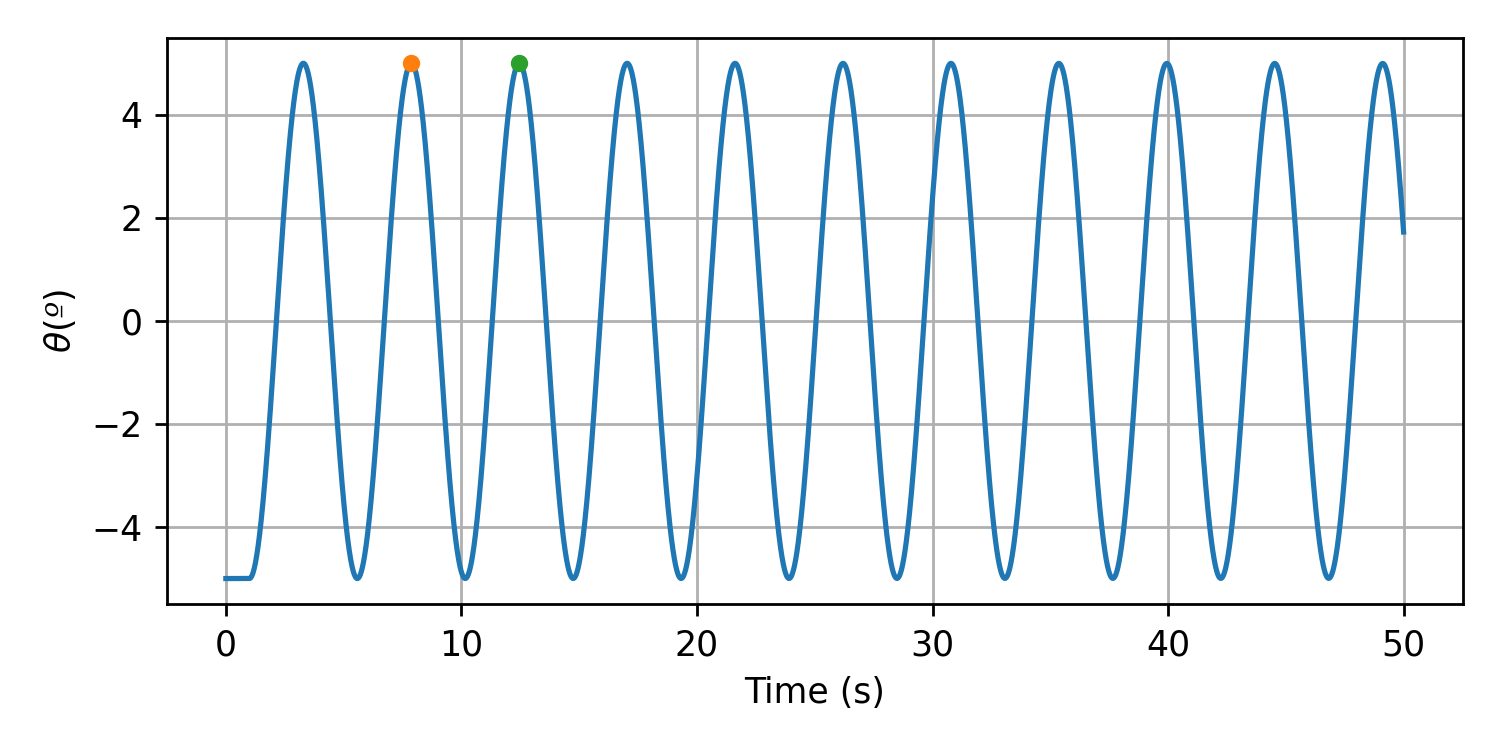

Oscillation period from simulation: T = 4.58 s


In [13]:
time = pend.T[:,0]                            # gets the simulated times
theta = np.rad2deg(pend.get_values('theta'))  # gets the values for theta (and covert them from rad to deg)

# this is just to find the period of the theta oscillation:
idx_1 = np.where(theta==np.max(theta[(time>7)&(time<11)]))[0][0]     
idx_2 = np.where(theta==np.max(theta[(time>10)&(time<14)]))[0][0]
t_1 = time[idx_1]
t_2 = time[idx_2]

period_sim = t_2 - t_1

# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(pend.T, np.rad2deg(pend.get_values('theta')), label=f'$\theta$')
axes.plot(t_1, np.rad2deg(pend.get_values('theta')[idx_1]),'o',ms=4)
axes.plot(t_2, np.rad2deg(pend.get_values('theta')[idx_2]),'o',ms=4)
axes.grid()
axes.set_ylabel('$\\theta (º)$')
axes.set_xlabel('Time (s)')
fig.tight_layout()
fig.show()

print(f'Oscillation period from simulation: T = {period_sim:0.2f} s')

### Animation of the results

The obtained results can be animated. 

In [15]:
times = pend.T
t_end = times[-1,0] 
N_steps = 1000
mask_values = pend.get_values('theta')
values = np.rad2deg(pend.get_values('theta'))
N_t = len(values)
mask = np.array([True]*N_t)
increment = np.abs((mask_values.max()-mask_values.min())/N_steps)
mask[0:(N_t-1)] =  np.abs(np.diff(mask_values))>increment
mask[0] = True
mask[:] = True
times_s = pend.T[mask]
values_s = values[mask]
values_p_x = pend.get_values('p_x')[mask]
values_p_y = pend.get_values('p_y')[mask]
values_f_x = np.abs(pend.get_values('f_x')[mask])
keyTimes = ""
keyPoints = ""
keyPoints_p_xy = ""
keyPoints_f_x = ""
for it in range(len(times_s)):
    keyTimes  += f'{times_s[it,0]/t_end};'
    keyPoints += f'{(-values_s[it])},71.4375,103.18749;' 
    keyPoints_p_xy += f'{(values_p_x[it])*10},{-(values_p_y[it]-values_p_y[0])*10};' 
    keyPoints_f_x  += f'{(values_f_x[it])*0.1},{1};' 
keyTimes  = keyTimes[:-1].replace("'",'"')    
keyPoints = keyPoints[:-1].replace("'",'"') 
keyPoints_p_xy = keyPoints_p_xy[:-1].replace("'",'"') 
keyPoints_f_x = keyPoints_f_x[:-1].replace("'",'"') 

HTML(f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   id="svg8"
   version="1.1"
   viewBox="0 0 34.504853 29.236458" 
   height="400"
   width="800">
  <defs
     id="defs2" />
  <metadata
     id="metadata5">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
   <defs
     id="defs2">
    <marker
       style="overflow:visible"
       id="Arrow1Sstart"
       refX="0.0"
       refY="0.0"
       orient="auto">
      <path
         transform="scale(0.2) translate(6,0)"
         style="fill-rule:evenodd;stroke:#000000;stroke-width:1pt;stroke-opacity:1;fill:#000000;fill-opacity:1"
         d="M 0.0,0.0 L 5.0,-5.0 L -12.5,0.0 L 5.0,5.0 L 0.0,0.0 z "
         id="path941" />
    </marker>
  </defs>
  <g
     id="layer1"
     transform="translate(-54.19671,-130.9026)">
    <rect
       style="fill:none;stroke:none;stroke-width:0.132292;stop-color:#000000"
       id="rect923"
       width="34.372559"
       height="29.104166"
       x="54.262856"
       y="130.96875" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 4.957897,56.66896"
       id="path846-1" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 9.87805,56.0212"
       id="path846-1-9" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 -4.957892,56.66896"
       id="path846-1-9-6" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 -9.878052,56.02121"
       id="path846-1-9-6-9" />
    <path
       style="fill:none;stroke:#555555;stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
       id="path833"
       d="m 123.47135,103.1875 a 52.033852,52.033405 0 0 1 -26.016925,45.06225 52.033852,52.033405 0 0 1 -52.033852,0 52.033852,52.033405 0 0 1 -26.016925,-45.06225" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 5e-6,56.88542"
       id="path846" />
    <g
       id="g890"
       transform="rotate(-0.0128064,71.440161,103.18771)">
      <rect
         style="fill:#337ab7;stroke:none;stroke-width:0.499999;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
         id="rect885"
         width="0.39323467"
         height="52.916477"
         x="71.262543"
         y="101.9165"
         transform="matrix(0.99999974,-7.2630252e-4,-1.7091586e-4,0.99999999,0,0)" />
      <circle
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.132292;stop-color:#000000"
         id="path868"
         cx="71.4375"
         cy="155.25372"
         r="1.3838332" />
      <circle
         style="fill:#337ab7;stroke:none;stroke-width:0.132292;stop-color:#000000"
         id="path868-1"
         cx="71.4375"
         cy="103.18751"
         r="1.5198423" />
      <path
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 71.425846,155.31042 -4.73e-4,2.11667"
         id="path925" />
    <animateTransform attributeType="xml" attributeName="transform" type="rotate"
    calcMode="discrete"
    values={keyPoints}
        keyTimes={keyTimes} 
        dur="{t_end}s" repeatCount="indefinite" />
    </g>
<rect transform="translate(72.8,154.6)" id="Rectangle-1" fill="#f0ad4e" sketch:type="MSShapeGroup" x="0" y="0" width="1" height="1">
        <animateTransform attributeName="transform"
             type="translate"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_p_xy}
             dur="{t_end}s"
             repeatCount="indefinite"
        />
<animateTransform attributeName="transform"
             type="scale"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_f_x}
             dur="{t_end}s"
             repeatCount="indefinite"
        />
</rect>
  </g>
</svg>
''')

Let's supposed that we want to show that the period depends very little on the amplitude (if we consider a samll one). We can simulate twice and then compare the results:

- `p_5`: system for initial position of 5º
- `p_10`: system for initial position of 10º

In [16]:
p_5  = pendulum_class()
p_10 = pendulum_class()
M = 30.0
L = 5.21

p_5.initialize([{'f_x':0,'M':M,'L':L,'theta':np.deg2rad(0)}],-1)
p_5.simulate([{'t_end':1, 'theta':np.deg2rad(-5)},
            {'t_end':50,'f_x':0}],'prev');

p_10.initialize([{'f_x':0,'M':M,'L':L,'theta':np.deg2rad(0)}],-1)
p_10.simulate([{'t_end':1, 'theta':np.deg2rad(-10)},
            {'t_end':50,'f_x':0}],'prev');

In [17]:
times = p_5.T
t_end = times[-1,0] 
N_steps = 1000
mask_values = p_5.get_values('theta')
values = np.rad2deg(p_5.get_values('theta'))
N_t = len(values)
mask = np.array([True]*N_t)
increment = np.abs((mask_values.max()-mask_values.min())/N_steps)
mask[0:(N_t-1)] =  np.abs(np.diff(mask_values))>increment
mask[0] = True
mask[:] = True
times_s = p_5.T[mask]
values_s = values[mask]

keyTimes = ""
keyPoints = ""
for it in range(len(times_s)):
    keyTimes  += f'{times_s[it,0]/t_end};'
    keyPoints += f'{(-values_s[it])},71.4375,103.18749;' 
keyTimes_5  = keyTimes[:-1].replace("'",'"')    
keyPoints_5 = keyPoints[:-1].replace("'",'"') 

times = p_10.T
t_end = times[-1,0] 
N_steps = 1000
mask_values = p_10.get_values('theta')
values = np.rad2deg(p_10.get_values('theta'))
N_t = len(values)
mask = np.array([True]*N_t)
increment = np.abs((mask_values.max()-mask_values.min())/N_steps)
mask[0:(N_t-1)] =  np.abs(np.diff(mask_values))>increment
mask[0] = True
mask[:] = True
times_s = p_10.T[mask]
values_s = values[mask]

keyTimes = ""
keyPoints = ""
for it in range(len(times_s)):
    keyTimes  += f'{times_s[it,0]/t_end};'
    keyPoints += f'{(-values_s[it])},71.4375,103.18749;' 
keyTimes_10  = keyTimes[:-1].replace("'",'"')    
keyPoints_10 = keyPoints[:-1].replace("'",'"') 

HTML(f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   id="svg8"
   version="1.1"
   viewBox="0 0 34.504853 29.236458" 
   height="400"
   width="800">
  <defs
     id="defs2" />
  <metadata
     id="metadata5">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     id="layer1"
     transform="translate(-54.19671,-130.9026)">
    <rect
       style="fill:none;stroke:none;stroke-width:0.132292;stop-color:#000000"
       id="rect923"
       width="34.372559"
       height="29.104166"
       x="54.262856"
       y="130.96875" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 4.957897,56.66896"
       id="path846-1" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 9.87805,56.0212"
       id="path846-1-9" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 -4.957892,56.66896"
       id="path846-1-9-6" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 -9.878052,56.02121"
       id="path846-1-9-6-9" />
    <path
       style="fill:none;stroke:#555555;stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
       id="path833"
       d="m 123.47135,103.1875 a 52.033852,52.033405 0 0 1 -26.016925,45.06225 52.033852,52.033405 0 0 1 -52.033852,0 52.033852,52.033405 0 0 1 -26.016925,-45.06225" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 5e-6,56.88542"
       id="path846" />
    <g
       id="g890"
       transform="rotate(-0.0128064,71.440161,103.18771)">
      <rect
         style="fill:#337ab7;stroke:none;stroke-width:0.499999;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
         id="rect885"
         width="0.39323467"
         height="52.916477"
         x="71.262543"
         y="101.9165"
         transform="matrix(0.99999974,-7.2630252e-4,-1.7091586e-4,0.99999999,0,0)" />
      <circle
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.132292;stop-color:#000000"
         id="path868"
         cx="71.4375"
         cy="155.25372"
         r="1.3838332" />
      <circle
         style="fill:#337ab7;stroke:none;stroke-width:0.132292;stop-color:#000000"
         id="path868-1"
         cx="71.4375"
         cy="103.18751"
         r="1.5198423" />
      <path
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 71.425846,155.31042 -4.73e-4,2.11667"
         id="path925" />
    <animateTransform attributeType="xml" attributeName="transform" type="rotate"
    calcMode="discrete"
    values={keyPoints_5}
        keyTimes={keyTimes_5} 
        dur="{t_end}s" repeatCount="indefinite" />
    </g>
    <g
       id="g890"
       transform="rotate(-0.0128064,71.440161,103.18771)">
      <rect
         style="fill:#337ab7;stroke:none;stroke-width:0.499999;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
         id="rect885"
         width="0.39323467"
         height="52.916477"
         x="71.262543"
         y="101.9165"
         transform="matrix(0.99999974,-7.2630252e-4,-1.7091586e-4,0.99999999,0,0)" />
      <circle
         style="fill:#5cb85c;stroke:#5cb85c;stroke-width:0.132292;stop-color:#000000"
         id="path868"
         cx="71.4375"
         cy="155.25372"
         r="1.3838332" />
      <circle
         style="fill:#337ab7;stroke:none;stroke-width:0.132292;stop-color:#000000"
         id="path868-1"
         cx="71.4375"
         cy="103.18751"
         r="1.5198423" />
      <path
         style="fill:#5cb85c;stroke:#5cb85c;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 71.425846,155.31042 -4.73e-4,2.11667"
         id="path925" />
    <animateTransform attributeType="xml" attributeName="transform" type="rotate"
    calcMode="discrete"
    values={keyPoints_10}
        keyTimes={keyTimes_10} 
        dur="{t_end}s" repeatCount="indefinite" />
    </g>
  </g>
</svg>
''')

Now we can check that mass does not affect the oscillation period:

In [21]:
p_m30 = pendulum_class()
p_m300 = pendulum_class()

p_m30.initialize([{'f_x':0,'M':30,'L':L,'theta':np.deg2rad(0)}],-1)
p_m300.initialize([{'f_x':0,'M':300,'L':L,'theta':np.deg2rad(0)}],-0.1)
p_m300.report_x()
p_m300.report_y()
ssa.eval_ss(p_m30)
ssa.eval_ss(p_m300)

eig_df_m30 = ssa.damp_report(p_m30)
eig_df_m300 = ssa.damp_report(p_m300)


p_x   = -0.00
p_y   = -5.21
v_x   =  0.00
v_y   =  0.00
lam   = 282.44
theta = -0.00


In [22]:
freq_m30 = eig_df_m30['Freq.']['Mode 1']   # frequency of Mode 1 (Hz)
freq_m300 = eig_df_m300['Freq.']['Mode 1']   # frequency of Mode 1 (Hz)

print(f'Oscillation period from small signal analysis with M = 30 kg:  T = {1/freq_m30:0.2f} s')
print(f'Oscillation period from small signal analysis with M = 300 kg: T = {1/freq_m300:0.2f} s')

Oscillation period from small signal analysis with M = 30 kg:  T = 4.58 s
Oscillation period from small signal analysis with M = 300 kg: T = 4.58 s


In [28]:
pend.simulate([{'t_end':1, 'theta':np.deg2rad(-10)},  # initilize the system with theta = -5º and run until t=1s
               {'t_end':1.5,'f_x':20.0},               # release the pendulum by but applying a positive force equal
               {'t_end':10,'f_x':0.0}],                # release the pendulum
               'prev');                              

In [42]:
times = pend.T
t_end = times[-1,0] 
N_steps = 1000
mask_values = pend.get_values('theta')
values = np.rad2deg(pend.get_values('theta'))
N_t = len(values)
mask = np.array([True]*N_t)
increment = np.abs((mask_values.max()-mask_values.min())/N_steps)
mask[0:(N_t-1)] =  np.abs(np.diff(mask_values))>increment
mask[0] = True
mask[:] = True
times_s = pend.T[mask]
values_s = values[mask]
values_p_x = pend.get_values('p_x')[mask]
values_p_y = pend.get_values('p_y')[mask]
values_f_x = -pend.get_values('f_x')[mask] - 50*np.sign(pend.get_values('f_x')[mask])
keyTimes = ""
keyPoints = ""
keyPoints_p_xy = ""
keyPoints_f_x = ""
for it in range(len(times_s)):
    keyTimes  += f'{times_s[it,0]/t_end};'
    keyPoints += f'{(-values_s[it])},71.4375,103.18749;' 
    keyPoints_p_xy += f'{(values_p_x[it])*10},{-(values_p_y[it]-values_p_y[0])*10};' 
    keyPoints_f_x  += f'{(values_f_x[it])*0.1},{1};' 
keyTimes  = keyTimes[:-1].replace("'",'"')    
keyPoints = keyPoints[:-1].replace("'",'"') 
keyPoints_p_xy = keyPoints_p_xy[:-1].replace("'",'"') 
keyPoints_f_x = keyPoints_f_x[:-1].replace("'",'"') 

HTML(f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   id="svg8"
   version="1.1"
   viewBox="0 0 34.504853 29.236458" 
   height="400"
   width="800">
  <defs
     id="defs2" />
  <metadata
     id="metadata5">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
   <defs
     id="defs2">
    <marker
       style="overflow:visible"
       id="Arrow1Sstart"
       refX="0.0"
       refY="0.0"
       orient="auto">
      <path
         transform="scale(0.2) translate(6,0)"
         style="fill-rule:evenodd;stroke:#000000;stroke-width:1pt;stroke-opacity:1;fill:#000000;fill-opacity:1"
         d="M 0.0,0.0 L 5.0,-5.0 L -12.5,0.0 L 5.0,5.0 L 0.0,0.0 z "
         id="path941" />
    </marker>
  </defs>
  <g
     id="layer1"
     transform="translate(-54.19671,-130.9026)">
<rect transform="translate(72.8,154.6)" id="Rectangle-1" fill="#f0ad4e" sketch:type="MSShapeGroup" x="0" y="-0.5" width="1" height="1">
        <animateTransform attributeName="transform"
             type="translate"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_p_xy}
             dur="{t_end}s"
             repeatCount="indefinite"
        />
<animateTransform attributeName="transform"
             type="scale"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_f_x}
             dur="{t_end}s"
             repeatCount="indefinite"
        />
</rect>  
    <rect
       style="fill:none;stroke:none;stroke-width:0.132292;stop-color:#000000"
       id="rect923"
       width="34.372559"
       height="29.104166"
       x="54.262856"
       y="130.96875" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 4.957897,56.66896"
       id="path846-1" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 9.87805,56.0212"
       id="path846-1-9" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 -4.957892,56.66896"
       id="path846-1-9-6" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 -9.878052,56.02121"
       id="path846-1-9-6-9" />
    <path
       style="fill:none;stroke:#555555;stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
       id="path833"
       d="m 123.47135,103.1875 a 52.033852,52.033405 0 0 1 -26.016925,45.06225 52.033852,52.033405 0 0 1 -52.033852,0 52.033852,52.033405 0 0 1 -26.016925,-45.06225" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 5e-6,56.88542"
       id="path846" />
    <g
       id="g890"
       transform="rotate(-0.0128064,71.440161,103.18771)">
      <rect
         style="fill:#337ab7;stroke:none;stroke-width:0.499999;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
         id="rect885"
         width="0.39323467"
         height="52.916477"
         x="71.262543"
         y="101.9165"
         transform="matrix(0.99999974,-7.2630252e-4,-1.7091586e-4,0.99999999,0,0)" />
      <circle
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.132292;stop-color:#000000"
         id="path868"
         cx="71.4375"
         cy="155.25372"
         r="1.3838332" />
      <circle
         style="fill:#337ab7;stroke:none;stroke-width:0.132292;stop-color:#000000"
         id="path868-1"
         cx="71.4375"
         cy="103.18751"
         r="1.5198423" />
      <path
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 71.425846,155.31042 -4.73e-4,2.11667"
         id="path925" />
    <animateTransform attributeType="xml" attributeName="transform" type="rotate"
    calcMode="discrete"
    values={keyPoints}
        keyTimes={keyTimes} 
        dur="{t_end}s" repeatCount="indefinite" />
    </g>

  </g>
</svg>
''')

## Control

In [47]:
Δt = 0.1
p_ctrl = pendulum_class()
times = np.arange(0,30,Δt)
p_ctrl.initialize([{'M':30,'L':5.21,'theta':np.deg2rad(-10)}],-1)

f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x = f_x_0
    if t>2.0:
        f_x = 0.0
    p_ctrl.run([{'t_end':t,'f_x':f_x}])
    
p_ctrl.post();


<IPython.core.display.Javascript object>


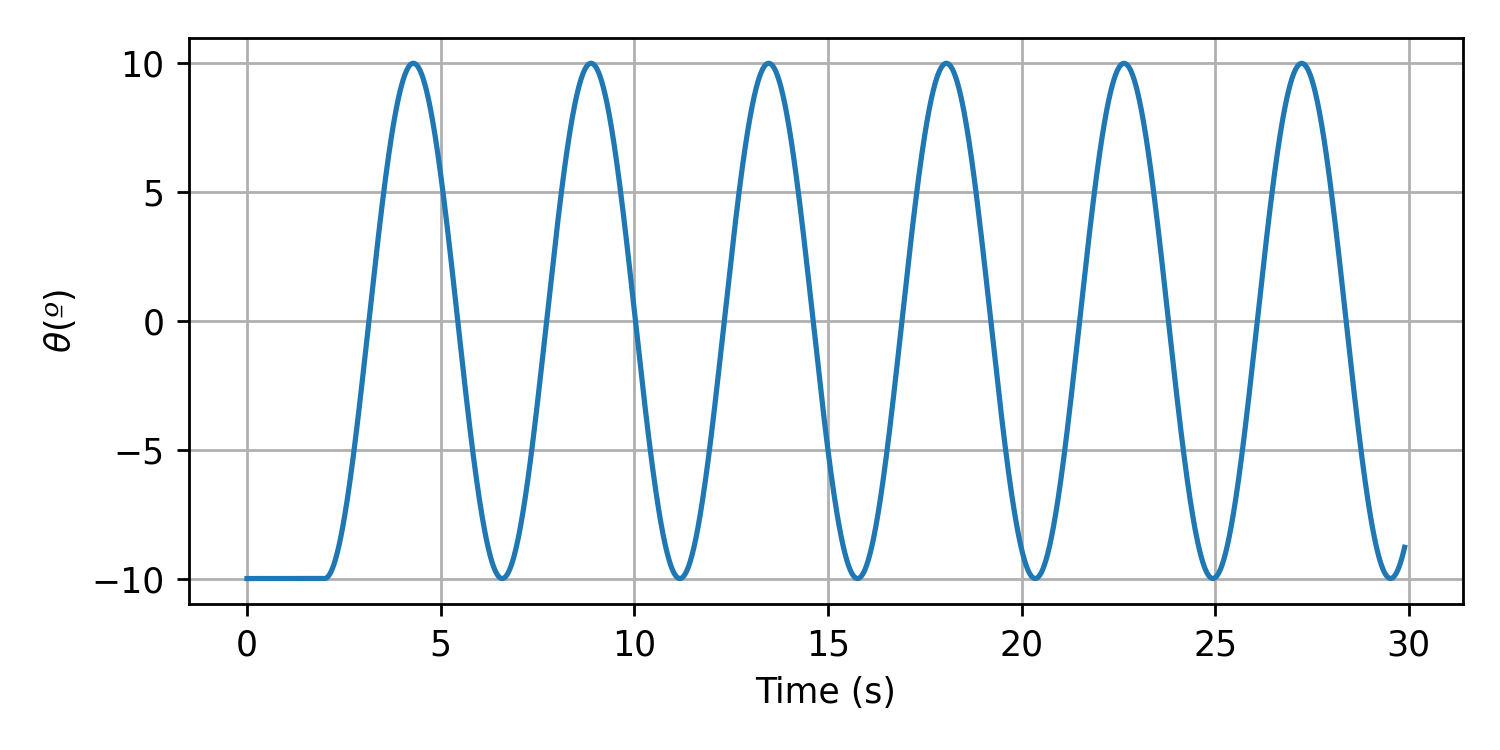

In [48]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(p_ctrl.T, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')

axes.grid()
axes.set_ylabel('$\\theta (º)$')
axes.set_xlabel('Time (s)')
fig.tight_layout()
fig.show()


Now we are going to propose a control law as follows:

$$
\Delta f_x = - K v_x
$$

$$
f_x = f_h + \Delta f_x 
$$

where $f_x$ is the hand effort and $\Delta f_x$ is the controller force increment.

In [76]:
Δt = 0.1
p_ctrl = pendulum_class()
times = np.arange(0,25,Δt)
p_ctrl.initialize([{'M':30,'L':5.21,'theta':np.deg2rad(-10)}],-1)

K = 20.0
f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x_hand = f_x_0
    if t>2.0:
        f_x_hand = 0.0
    
    v_x = p_ctrl.get_value('v_x')        # speed in x measurement
     
    f_x = f_x_hand - K*v_x            # control law
    
    p_ctrl.run([{'t_end':t,'f_x':f_x}])  # simulation until t(k+1) =  Δt + t(k) with the updated f_x force 
    
p_ctrl.post();  # required post processing


<IPython.core.display.Javascript object>


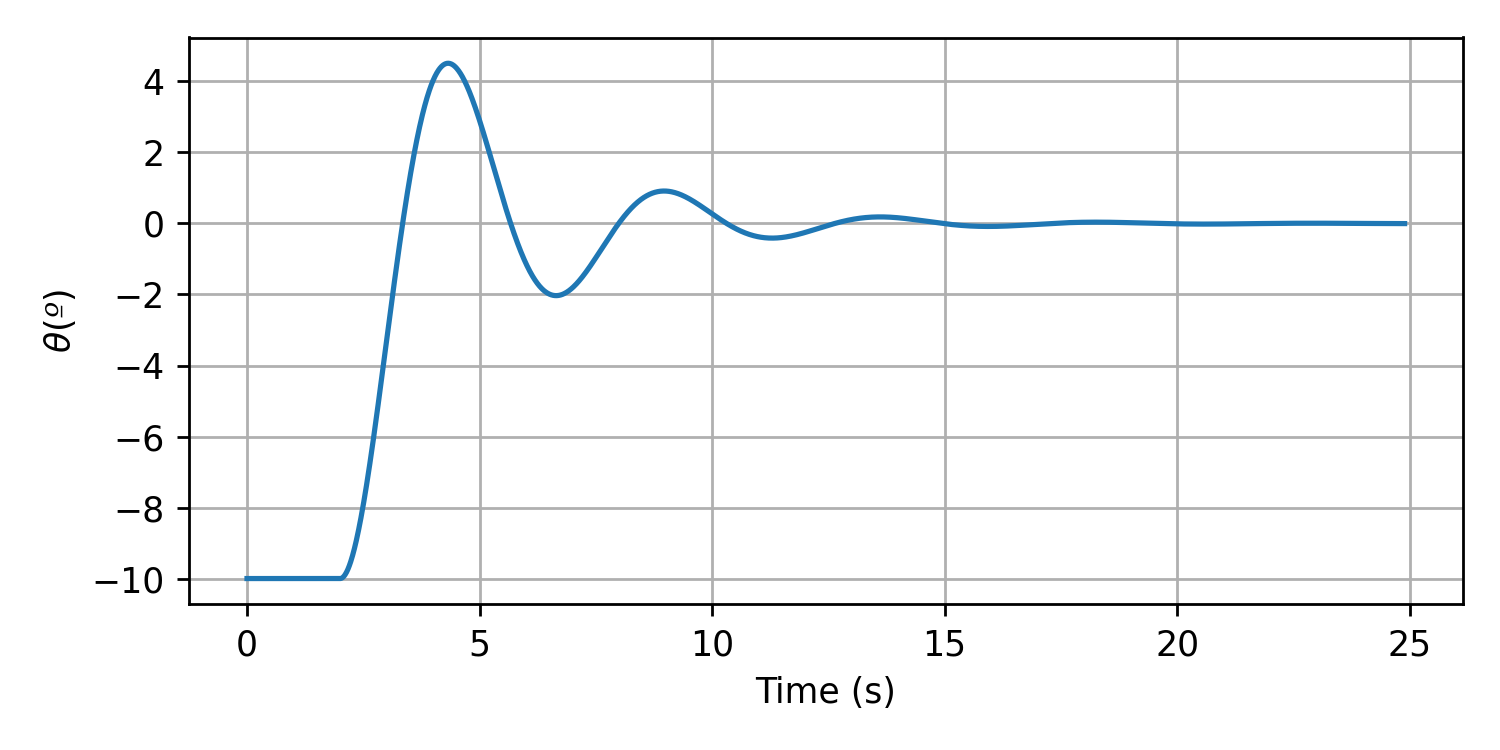

In [77]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(p_ctrl.T, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')

axes.grid()
axes.set_ylabel('$\\theta (º)$')
axes.set_xlabel('Time (s)')
fig.tight_layout()
fig.show()

In [78]:
pend = p_ctrl
times = pend.T
t_end = times[-1,0] 
N_steps = 1000
mask_values = pend.get_values('theta')
values = np.rad2deg(pend.get_values('theta'))
N_t = len(values)
mask = np.array([True]*N_t)
increment = np.abs((mask_values.max()-mask_values.min())/N_steps)
mask[0:(N_t-1)] =  np.abs(np.diff(mask_values))>increment
mask[0] = True
mask[:] = True
times_s = pend.T[mask]
values_s = values[mask]
values_p_x = pend.get_values('p_x')[mask] - 0.13*np.sign(pend.get_values('f_x')[mask]) -0.14
values_p_y = pend.get_values('p_y')[mask]
values_f_x = -pend.get_values('f_x')[mask] 
keyTimes = ""
keyPoints = ""
keyPoints_p_xy = ""
keyPoints_f_x = ""
for it in range(len(times_s)):
    keyTimes  += f'{times_s[it,0]/t_end};'
    keyPoints += f'{(-values_s[it])},71.4375,103.18749;' 
    keyPoints_p_xy += f'{(values_p_x[it])*10},{-(values_p_y[it]-values_p_y[0])*10};' 
    keyPoints_f_x  += f'{(values_f_x[it])*0.1},{1};' 
keyTimes  = keyTimes[:-1].replace("'",'"')    
keyPoints = keyPoints[:-1].replace("'",'"') 
keyPoints_p_xy = keyPoints_p_xy[:-1].replace("'",'"') 
keyPoints_f_x = keyPoints_f_x[:-1].replace("'",'"') 

HTML(f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   id="svg8"
   version="1.1"
   viewBox="0 0 34.504853 29.236458" 
   height="400"
   width="800">
  <defs
     id="defs2" />
  <metadata
     id="metadata5">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
   <defs
     id="defs2">
    <marker
       style="overflow:visible"
       id="Arrow1Sstart"
       refX="0.0"
       refY="0.0"
       orient="auto">
      <path
         transform="scale(0.2) translate(6,0)"
         style="fill-rule:evenodd;stroke:#000000;stroke-width:1pt;stroke-opacity:1;fill:#000000;fill-opacity:1"
         d="M 0.0,0.0 L 5.0,-5.0 L -12.5,0.0 L 5.0,5.0 L 0.0,0.0 z "
         id="path941" />
    </marker>
  </defs>
  <g
     id="layer1"
     transform="translate(-54.19671,-130.9026)">
<rect transform="translate(72.8,154.6)" id="Rectangle-1" fill="#f0ad4e" sketch:type="MSShapeGroup" x="-0.1" y="-0.5" width="1" height="1">
        <animateTransform attributeName="transform"
             type="translate"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_p_xy}
             dur="{t_end}s"
             repeatCount="indefinite"
        />
<animateTransform attributeName="transform"
             type="scale"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_f_x}
             dur="{t_end}s"
             repeatCount="indefinite"
        />

</rect>  
    <rect
       style="fill:none;stroke:none;stroke-width:0.132292;stop-color:#000000"
       id="rect923"
       width="34.372559"
       height="29.104166"
       x="54.262856"
       y="130.96875" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 4.957897,56.66896"
       id="path846-1" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 9.87805,56.0212"
       id="path846-1-9" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 -4.957892,56.66896"
       id="path846-1-9-6" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 -9.878052,56.02121"
       id="path846-1-9-6-9" />
    <path
       style="fill:none;stroke:#555555;stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
       id="path833"
       d="m 123.47135,103.1875 a 52.033852,52.033405 0 0 1 -26.016925,45.06225 52.033852,52.033405 0 0 1 -52.033852,0 52.033852,52.033405 0 0 1 -26.016925,-45.06225" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 5e-6,56.88542"
       id="path846" />
    <g
       id="g890"
       transform="rotate(-0.0128064,71.440161,103.18771)">
      <rect
         style="fill:#337ab7;stroke:none;stroke-width:0.499999;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
         id="rect885"
         width="0.39323467"
         height="52.916477"
         x="71.262543"
         y="101.9165"
         transform="matrix(0.99999974,-7.2630252e-4,-1.7091586e-4,0.99999999,0,0)" />
      <circle
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.132292;stop-color:#000000"
         id="path868"
         cx="71.4375"
         cy="155.25372"
         r="1.3838332" />
      <circle
         style="fill:#337ab7;stroke:none;stroke-width:0.132292;stop-color:#000000"
         id="path868-1"
         cx="71.4375"
         cy="103.18751"
         r="1.5198423" />
      <path
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 71.425846,155.31042 -4.73e-4,2.11667"
         id="path925" />
    <animateTransform attributeType="xml" attributeName="transform" type="rotate"
    calcMode="discrete"
    values={keyPoints}
        keyTimes={keyTimes} 
        dur="{t_end}s" repeatCount="indefinite" />
    </g>


        
  </g>
</svg>
''')

In [97]:
Δt = 0.1
p_ctrl = pendulum_class()
times = np.arange(0,25,Δt)
p_ctrl.initialize([{'M':30,'L':5.21,'theta':np.deg2rad(-10)}],-1)

K = 20.0
f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x_hand = f_x_0
    if t>2.0:
        f_x_hand = 0.0
    
    p_x = p_ctrl.get_value('p_x')        # position in x measurement
    v_x = p_ctrl.get_value('v_x')        # speed in x measurement
     
    f_x = f_x_hand - np.sign(v_x)*5            # control law
    
    p_ctrl.run([{'t_end':t,'f_x':f_x}])  # simulation until t(k+1) =  Δt + t(k) with the updated f_x force 
    
p_ctrl.post();  # required post processing

<IPython.core.display.Javascript object>


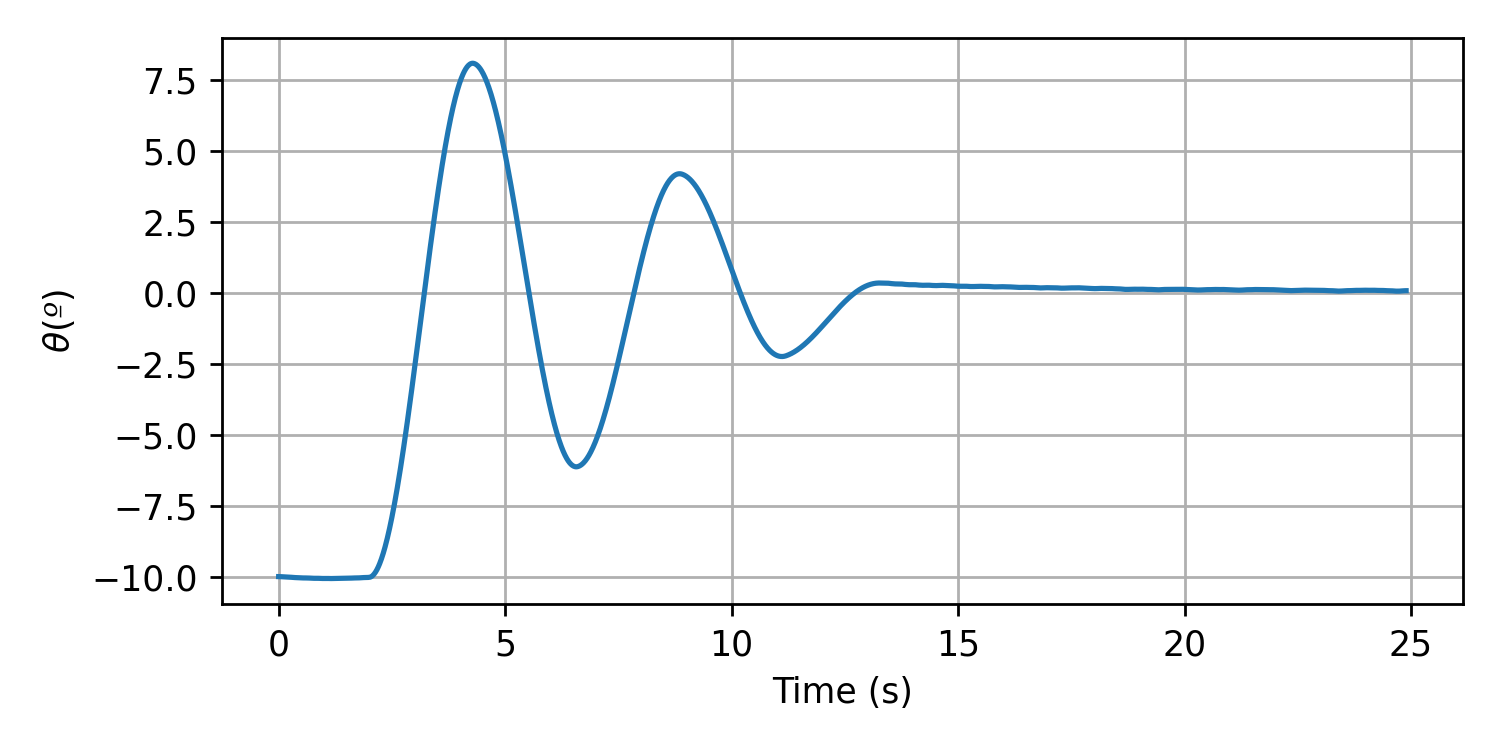

In [98]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(p_ctrl.T, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')

axes.grid()
axes.set_ylabel('$\\theta (º)$')
axes.set_xlabel('Time (s)')
fig.tight_layout()
fig.show()

In [99]:
pend = p_ctrl
times = pend.T
t_end = times[-1,0] 
N_steps = 1000
mask_values = pend.get_values('theta')
values = np.rad2deg(pend.get_values('theta'))
N_t = len(values)
mask = np.array([True]*N_t)
increment = np.abs((mask_values.max()-mask_values.min())/N_steps)
mask[0:(N_t-1)] =  np.abs(np.diff(mask_values))>increment
mask[0] = True
mask[:] = True
times_s = pend.T[mask]
values_s = values[mask]
values_p_x = pend.get_values('p_x')[mask] - 0.13*np.sign(pend.get_values('f_x')[mask]) -0.14
values_p_y = pend.get_values('p_y')[mask]
values_f_x = -pend.get_values('f_x')[mask] 
keyTimes = ""
keyPoints = ""
keyPoints_p_xy = ""
keyPoints_f_x = ""
for it in range(len(times_s)):
    keyTimes  += f'{times_s[it,0]/t_end};'
    keyPoints += f'{(-values_s[it])},71.4375,103.18749;' 
    keyPoints_p_xy += f'{(values_p_x[it])*10},{-(values_p_y[it]-values_p_y[0])*10};' 
    keyPoints_f_x  += f'{(values_f_x[it])*0.1},{1};' 
keyTimes  = keyTimes[:-1].replace("'",'"')    
keyPoints = keyPoints[:-1].replace("'",'"') 
keyPoints_p_xy = keyPoints_p_xy[:-1].replace("'",'"') 
keyPoints_f_x = keyPoints_f_x[:-1].replace("'",'"') 

HTML(f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   id="svg8"
   version="1.1"
   viewBox="0 0 34.504853 29.236458" 
   height="400"
   width="800">
  <defs
     id="defs2" />
  <metadata
     id="metadata5">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
   <defs
     id="defs2">
    <marker
       style="overflow:visible"
       id="Arrow1Sstart"
       refX="0.0"
       refY="0.0"
       orient="auto">
      <path
         transform="scale(0.2) translate(6,0)"
         style="fill-rule:evenodd;stroke:#000000;stroke-width:1pt;stroke-opacity:1;fill:#000000;fill-opacity:1"
         d="M 0.0,0.0 L 5.0,-5.0 L -12.5,0.0 L 5.0,5.0 L 0.0,0.0 z "
         id="path941" />
    </marker>
  </defs>
  <g
     id="layer1"
     transform="translate(-54.19671,-130.9026)">
<rect transform="translate(72.8,154.6)" id="Rectangle-1" fill="#f0ad4e" sketch:type="MSShapeGroup" x="-0.1" y="-0.5" width="1" height="1">
        <animateTransform attributeName="transform"
             type="translate"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_p_xy}
             dur="{t_end}s"
             repeatCount="indefinite"
        />
<animateTransform attributeName="transform"
             type="scale"
             additive="sum" 
             keyTimes = {keyTimes} 
             values = {keyPoints_f_x}
             dur="{t_end}s"
             repeatCount="indefinite"
        />

</rect>  
    <rect
       style="fill:none;stroke:none;stroke-width:0.132292;stop-color:#000000"
       id="rect923"
       width="34.372559"
       height="29.104166"
       x="54.262856"
       y="130.96875" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 4.957897,56.66896"
       id="path846-1" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 9.87805,56.0212"
       id="path846-1-9" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 -4.957892,56.66896"
       id="path846-1-9-6" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.437498,103.1875 -9.878052,56.02121"
       id="path846-1-9-6-9" />
    <path
       style="fill:none;stroke:#555555;stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
       id="path833"
       d="m 123.47135,103.1875 a 52.033852,52.033405 0 0 1 -26.016925,45.06225 52.033852,52.033405 0 0 1 -52.033852,0 52.033852,52.033405 0 0 1 -26.016925,-45.06225" />
    <path
       style="fill:none;stroke:#999999;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 71.4375,103.18749 5e-6,56.88542"
       id="path846" />
    <g
       id="g890"
       transform="rotate(-0.0128064,71.440161,103.18771)">
      <rect
         style="fill:#337ab7;stroke:none;stroke-width:0.499999;stroke-miterlimit:4;stroke-dasharray:1, 1;stroke-dashoffset:0;stop-color:#000000"
         id="rect885"
         width="0.39323467"
         height="52.916477"
         x="71.262543"
         y="101.9165"
         transform="matrix(0.99999974,-7.2630252e-4,-1.7091586e-4,0.99999999,0,0)" />
      <circle
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.132292;stop-color:#000000"
         id="path868"
         cx="71.4375"
         cy="155.25372"
         r="1.3838332" />
      <circle
         style="fill:#337ab7;stroke:none;stroke-width:0.132292;stop-color:#000000"
         id="path868-1"
         cx="71.4375"
         cy="103.18751"
         r="1.5198423" />
      <path
         style="fill:#d9534f;stroke:#d9534f;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 71.425846,155.31042 -4.73e-4,2.11667"
         id="path925" />
    <animateTransform attributeType="xml" attributeName="transform" type="rotate"
    calcMode="discrete"
    values={keyPoints}
        keyTimes={keyTimes} 
        dur="{t_end}s" repeatCount="indefinite" />
    </g>


        
  </g>
</svg>
''')